In [1]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, ErrorCode, plotTrajectoriesFile,AdvectionRK4_3D
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import netCDF4
import pandas
import os
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from matplotlib.pyplot import hold, figure, pcolor, colorbar, xlabel, ylabel, title, draw, quiver, show, savefig
import cmocean as cm
%matplotlib inline

In [4]:
globfiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridU01.nc"]
globfile = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridV01.nc"]
glb = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridW01.nc"]
tfiles = ["/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridT01.nc"]
filenames = {'U': globfiles,'V': globfile,'W': glb, "temp": tfiles}
variables = {'U': 'vozocrtx','V': 'vomecrty','W': 'vovecrtz', 'temp':'votemper'}
dimensions = {'lat': 'nav_lat','lon': 'nav_lon','time': 'time_counter','depth':'depth'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)

def Argo(particle, fieldset, time, dt):
    x = 0
    particle.age = particle.age + math.fabs(dt)/(86400)
    print particle.age
    while x <= 365:
        if particle.age >= x and particle.age <= x + 1: #droping down 1 = 1 day to sink down
            if particle.depth <= 1000:
                particle.depth = particle.depth + 1000/dt
            else:
                particle.depth = particle.depth
        elif particle.age >= x + 1 and particle.age <= x + 9: #remains at the 1000 m for 9 days 
            particle.depth = 1000
        elif particle.age > x + 9 and particle.age <= x + 10: #comes up on day 10
            if particle.depth >= 4:
                particle.depth = particle.depth - 1000/dt
            else:
                particle.depth = 4
        elif particle.age > x + 10 and particle.age <= x + 11: #between day 10 and day 11 it surfaces
            particle.depth = 4
        else:
            particle.depth = particle.depth
            #stays at surface until next run, i.e. for 1 day 
            #because at x = 12 it sinks again
        x = x + 12
    
def DeleteParticle(particle, fieldset, time, dt):
    particle.delete()
    
def SampleTemp(particle, fieldset, time, dt):
    particle.temp = fieldset.temp[time, particle.lon, particle.lat, particle.depth]

lonW = -10  #western part of deployment box
lonE = -30  #eastern part of deployment box
latS = -65 #southern part of deployment box
latN = -55 #northern part of deployment box
particles = 1 #number of particles one wants to deploy
days = 23 #simulation time

lons, lats = np.meshgrid(np.linspace(lonW,lonE,np.sqrt(particles)), np.linspace(latN,latS,np.sqrt(particles)))

class ForamParticle(JITParticle):
    temp = Variable('temp', dtype=np.float32, initial=np.nan)
    age = Variable('age', dtype=np.float32, initial=0.)
    
pset = ParticleSet(fieldset=fieldset, pclass=ForamParticle, lon=lons, lat=lats)

kernels = pset.Kernel(AdvectionRK4_3D) + Argo + SampleTemp
 
os.remove("testing3.nc")
output_file = pset.ParticleFile(name="testing3")
pset.execute(kernels, starttime=datetime(2008, 1, 1), runtime=timedelta(days=60),
             dt=timedelta(minutes=5), interval=timedelta(hours=1),output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

/Users/hart-davis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
INFO: Note that positive vertical velocity is assumed DOWNWARD by AdvectionRK4_3D
INFO: Compiled ForamParticleAdvectionRK4_3DArgoSampleTemp ==> /var/folders/r4/54mc4t2559d_d1fnkl99m38r0000gn/T/parcels-501/7201651b2e962d25d32b9cf9581e1b05.so


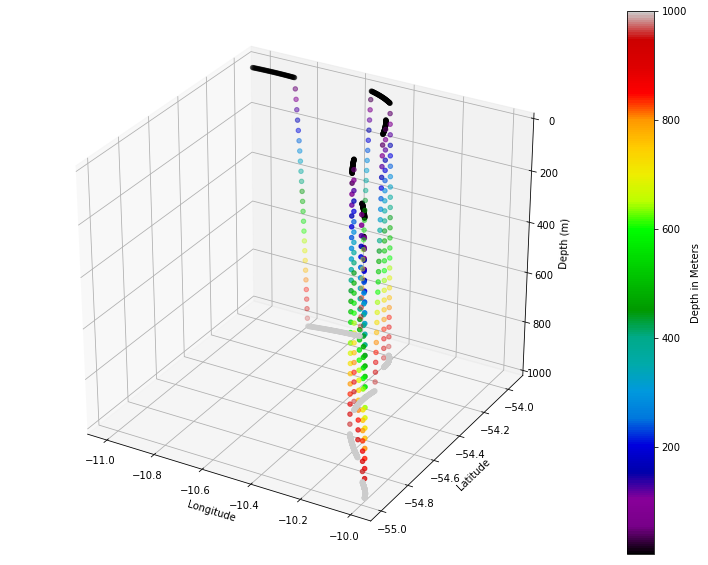

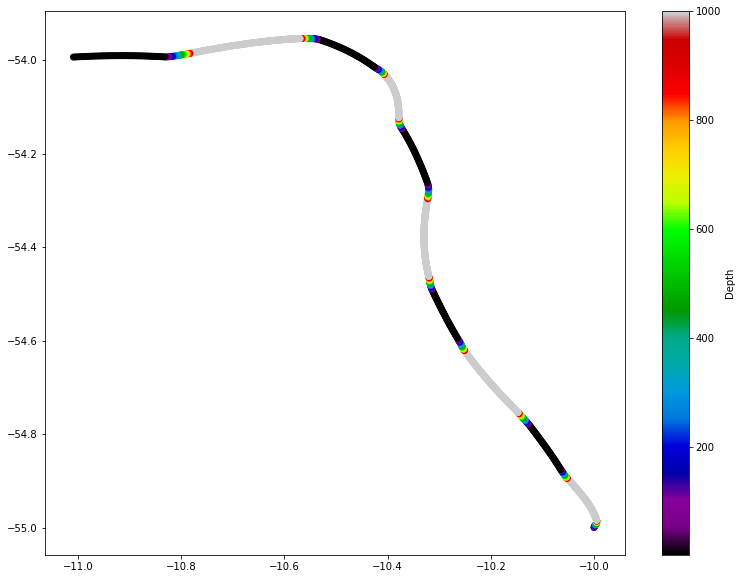

In [11]:
nc = netCDF4.Dataset("testing3.nc")
lon = nc.variables["lon"][:]
lat = nc.variables["lat"][:]

ncd = netCDF4.Dataset('/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridU01.nc')
ncf = netCDF4.Dataset('/Users/hart-davis/Desktop/luke_gregor/BIOSATLANTIC12-CNCRAD07A_y2007m12d31_gridV01.nc')

lonx = ncd.variables["nav_lon"][:]
laty = ncd.variables["nav_lat"][:]
east = ncd.variables["vozocrtx"][0,0]
north = ncf.variables["vomecrty"][0,0]
figure1 = plt.figure(figsize=(13, 10), dpi=80, facecolor='w', edgecolor='k')

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')

x = nc.variables["lon"][:]
y = nc.variables["lat"][:]
z1 = nc.variables["z"][:]

c = nc.variables["time"][:]
a = c - c[0,0]
c = a/(3600*24)
temp = nc.variables["temp"][:]

cb = ax.scatter(x[:], y[:], z1[:], c=z1[:],cmap=plt.cm.spectral,s=20,marker="o")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(1000,0)
cbar = plt.colorbar(cb)
cbar.set_label("Depth in Meters")
plt.show()

fig = plt.figure(figsize=(13,10))

ca = plt.scatter(x,y, c=z1, cmap = plt.cm.spectral)
caar = plt.colorbar(ca)
caar.set_label("Depth")
plt.show()

In [8]:
ar = netCDF4.Dataset("/Users/hart-davis/Desktop/Argo_3901917.nc")
alon = ar.variables["LONGITUDE"][:]
alat = ar.variables["LATITUDE"][:]



alon[0]

30.610479999999999

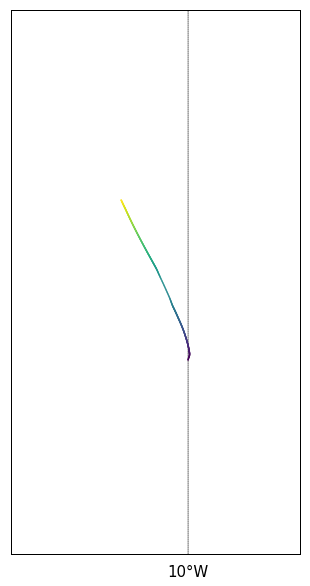

In [14]:
x = nc.variables["lon"][:]
y = nc.variables["lat"][:]
z1 = nc.variables["z"][:]
c = nc.variables["time"][:]
age = nc.variables["age"][:]

m = Basemap(projection = "merc", resolution="i",llcrnrlon = x.min()-0.4, 
            llcrnrlat = y.min()-0.4, urcrnrlon = x.max()+0.4, urcrnrlat = y.max()+0.4,lat_0= -20,lon_0 = 0)
fig = plt.figure(figsize=(13,10))

x,y = m(x,y)

m.scatter(x,y,1,c=c, marker = ".", alpha = 1, zorder=3)

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
#m.bluemarble()
m.drawparallels(np.arange(-90.,99.,10), color="k",labels=[1,0,0,0],fontsize=15)
m.drawmeridians(np.arange(-180.,180.,10), color="k",labels=[0,0,0,1],fontsize=15)

plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape

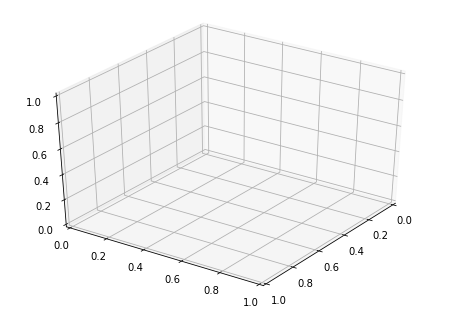

In [13]:
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
import cmocean as cm

fig = plt.figure()
ax = Axes3D(fig)

globfiles = "/Users/hart-davis/Desktop/Scripts/GEBCO_2014_6x6min_Global.nc"

ncc = netCDF4.Dataset(globfiles)

ssh = ncc.variables["Height"][:,:]
lon = ncc.variables["lon"][:]
lat = ncc.variables["lat"][:]

a = np.where((lat >= -38) & (lat <=8))[0]
b = np.where((lon>=10) & (lon<=30))[0]

xx, yy = np.meshgrid(lon[b],lat[a])

ax.view_init(35, 35)
ax.plot_surface(xx,yy,ssh[a], rstride=1, cstride=1, cmap=cm.cm.balance,linewidth=1, antialiased=True)
plt.show()

In [132]:
x=0
while x<=120:
     print x
     x = x + 12

0
12
24
36
48
60
72
84
96
108
120
